# Description
This notebook creates the two 3D plots for building graphical intuition about calibration models.

The plots are created based on a real calibration model and rendered with [POV-Ray](povray.org) because matplotlib couldn't handle the overlapping polygons correctly.

In [1]:
import numpy
import pathlib
import scipy
import ipywidgets
import ipyvolume

import calibr8
import models

# Load Model

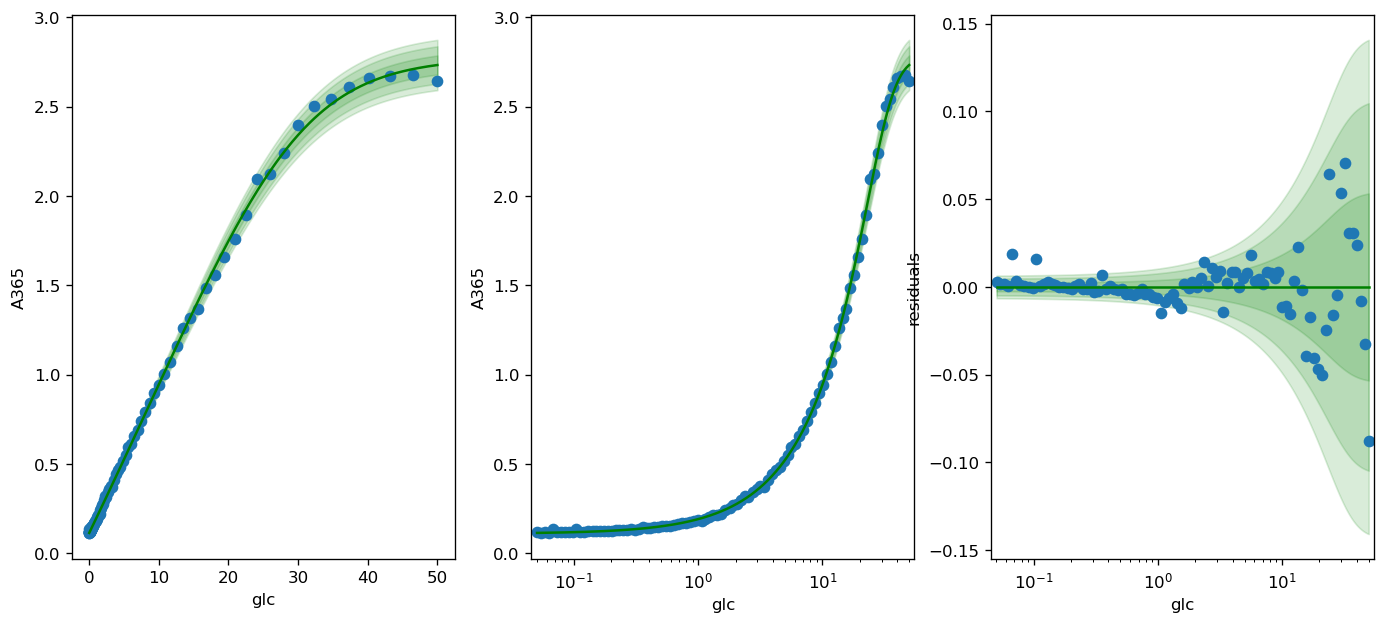

In [2]:
model = models.get_glucose_model()
calibr8.plot_model(model);

# 3D plot with `ipyvolume`

In [3]:
# The POV-Ray files are locaed in a subfolder
DP_PROCESSED = pathlib.Path(".").parent / "povray"


class PovWriter:
    """Writes POV-Ray polygons to a file, while plotting them with ipyvolumes."""

    def __init__(self, fn_povfile):
        self.fp_povfile = DP_PROCESSED / fn_povfile
        if self.fp_povfile.exists():
            self.fp_povfile.unlink()

    def add_surface(self, X, Y, Z, color: tuple):
        """
        Args:
            X: (2, resolution) - the x-coordinates of the circumference
            Y: (2, resolution) - the y-coordinates of the circumference (become Z for POV-Ray)
            Z: (2, resolution) - the z-coordinates of the circumference (become Y for POV-Ray)
        """
        obj = ipyvolume.plot_surface(X, Y, Z, color=color)
        obj.material.transparent = True
        obj.material.side = "DoubleSide"
        with open(self.fp_povfile, "a") as povfile:
            coords = numpy.array(
                [numpy.hstack([dim[0, :], dim[1, ::-1]]) for dim in [X, Y, Z]]
            ).T
            n_point = len(coords)
            color = f"rgbt <{color[0]}, {color[1]}, {color[2]}, {1 - color[3]}>"
            povfile.writelines(
                [
                    "polygon {",
                    "\n    %d\n" % n_point,
                    ",\n".join([f"    <{x}, {z}, {y}>" for x, y, z in coords]),
                    "\n    pigment { color %s}" % color,
                    "\n}\n\n",
                ]
            )
        return

In [4]:
resolution = 300
BOUNDS_X = (25, 60)
BOUNDS_Y = (1.8, 3.1)
BOUNDS_Z = (0, 25)


def dependent_likelihood(x, y):
    loc, scale, df = model.predict_dependent(x)
    result = scipy.stats.t.pdf(y, loc=loc, scale=scale, df=df)
    return result


def independent_likelihood(x, y):
    likelihoods = numpy.zeros_like(x)
    for i, x_ in enumerate(x):
        loc, scale, df = model.predict_dependent(x_)
        likelihoods[i] = numpy.prod(scipy.stats.t.pdf(y, loc=loc, scale=scale, df=df))
    result = numpy.array(likelihoods)
    return result


def normalize(X, Y, Z):
    area = numpy.trapz(Z[1, :], dx=1 / resolution)
    Z[1, :] /= area
    return X, Y, Z


def at_x(x, fun, base=0):
    X = numpy.array([numpy.repeat(x, resolution), numpy.repeat(x, resolution)])
    Y = numpy.array(
        [
            numpy.linspace(*BOUNDS_Y, resolution),
            numpy.linspace(*BOUNDS_Y, resolution),
        ]
    )
    Z = numpy.array([numpy.repeat(base, resolution), fun(x, Y[0, :])])
    return normalize(X, Y, Z)


def at_y(y, fun, base=0):
    Y = numpy.array([numpy.repeat(y, resolution), numpy.repeat(y, resolution)])
    X = numpy.array(
        [
            numpy.linspace(*BOUNDS_X, resolution),
            numpy.linspace(*BOUNDS_X, resolution),
        ]
    )
    Z = numpy.array([numpy.repeat(base, resolution), fun(X[0, :], y)])
    return normalize(X, Y, Z)


def plot_bands_to_ground(writer):
    # plot bands to the ground
    x_dense = numpy.linspace(*BOUNDS_X, resolution)
    mu, scale, df = model.predict_dependent(x_dense)
    for i, (q, alpha) in enumerate(
        reversed(list(zip([97.5, 95, 84, 52], [0.25, 0.25, 0.25, 1])))
    ):
        percent = q - (100 - q)
        lower = scipy.stats.t.ppf(q / 100, loc=mu, scale=scale, df=df)
        upper = scipy.stats.t.ppf(1 - q / 100, loc=mu, scale=scale, df=df)
        X = numpy.array([x_dense, x_dense])
        Y = numpy.array([lower, upper])
        Z = numpy.zeros((2, resolution)) + i / 50
        writer.add_surface(X, Y, Z, color=(0, 0.8, 0, alpha))
    return

## Plot dependent distributions

In [5]:
ipyvolume.clear()
writer = PovWriter("dependent.inc")
fig = ipyvolume.figure(width=400, height=300)

# plot bands to the ground
plot_bands_to_ground(writer)

# plot slices at x-coordinates
for x in numpy.linspace(*BOUNDS_X, num=10):
    writer.add_surface(*at_x(x=x, fun=dependent_likelihood), color=(0, 1, 0, 0.5))

# plot blue slices at y-coordinates
# for y in [2.2, 2.3, 2.65]:
#    writer.add_surface(
#        *at_y(y=y, fun=independent_likelihood),
#        color=(0, 0, 1, 0.5),
#    )

ipyvolume.xlim(*BOUNDS_X)
ipyvolume.ylim(*BOUNDS_Y)
ipyvolume.zlim(0, 20)
label = ipyvolume.ylabel("dependent")
ipyvolume.xlabel("independent")
ipyvolume.pylab.style.box_off()
# ipyvolume.pylab.style.axes_off(which='z')
ipyvolume.pylab.view(azimuth=54, elevation=-50, distance=2.5)
fig.camera.up = 0, 0, 1

ipyvolume.show()

## Plot posteriors on the independent variable

In [6]:
ipyvolume.clear()
writer = PovWriter("independent.inc")
fig = ipyvolume.figure(width=400, height=300)

# plot bands to the ground
plot_bands_to_ground(writer)

# plot slices at y-coordinates
y_obs = [2.45, 2.48, 2.5]
for y in y_obs:
    writer.add_surface(
        *at_y(y=y, fun=independent_likelihood),
        color=(0, 0, 1, 0.5),
    )

Y = numpy.array(
    [numpy.repeat(BOUNDS_Y[0], resolution), numpy.repeat(BOUNDS_Y[0], resolution)]
)
X = numpy.array(
    [
        numpy.linspace(*BOUNDS_X, resolution),
        numpy.linspace(*BOUNDS_X, resolution),
    ]
)
Z = numpy.array([numpy.repeat(0, resolution), independent_likelihood(X[0, :], y_obs)])
X, Y, Z = normalize(X, Y, Z)
area_by_x = scipy.integrate.cumtrapz(Z[1, :], dx=1 / resolution)
cdf = area_by_x / area_by_x[-1]
i_05 = numpy.argmin(numpy.abs(cdf - 0.05))
i_95 = numpy.argmin(numpy.abs(cdf - 0.95))
for ifrom, ito, color in [
    (0, i_05, (1, 0, 0, 0.8)),
    (i_05, i_95, (0, 0, 1, 0.8)),
    (i_95, -1, (1, 0, 0, 0.8)),
]:
    writer.add_surface(X[:, ifrom:ito], Y[:, ifrom:ito], Z[:, ifrom:ito], color=color)

ipyvolume.xlim(*BOUNDS_X)
ipyvolume.ylim(*BOUNDS_Y)
ipyvolume.zlim(0, 20)
label = ipyvolume.ylabel("dependent")
ipyvolume.xlabel("independent")
ipyvolume.pylab.style.box_off()
# ipyvolume.pylab.style.axes_off(which='z')
ipyvolume.pylab.view(azimuth=54, elevation=-50, distance=2.5)
fig.camera.up = 0, 0, 1

ipyvolume.show()

## Rendering the plot
This notebook just created the polygons from which the plot is created in POV-Ray.
To render the plot open `./povray/3Dplot.pov`.

In [7]:
%load_ext watermark
%watermark

Last updated: 2021-05-05T17:12:44.700350+02:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

